# Weighting, Matching, or Regression?

*Understanding and comparing different methods for conditional causal inference analysis*

INTRO

## Example

Assume we had blog on statistics and causal inference. To improve user experience, we are considering **releasing a dark mode**, and we would like to understand whether this new feature increases the time users spend on our blog. 

<img src="fig/modes.png" width="600px"/>

We are not a sophisticated company, therefore we do not run an AB test but we simply release the dark mode and we observe whether users use it or not and the time they spend on th blog. We know that there might be **selection**:  users that prefer the dark mode could have different reading preferences and this might complicate our causal analysis.

We can represent the data generating process with the following [**Directed Acyclic Graph (DAG)**](https://towardsdatascience.com/b63dc69e3d8c). If you are not familiar with DAGs, I have written a short [introduction here](https://towardsdatascience.com/b63dc69e3d8c).

```mermaid
flowchart TB
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

X1((gender))
X2((age))
X3((hours))
D((dark mode))
Y((read time))

D --> Y
X1 --> Y
X1 --> D
X2 --> D
X2 --> Y
X3 --> D
X3 --> Y

class D,Y included;
class X1,X2,X3 excluded;
```

We generate the simulated data using the data generating process `dgp_darkmode()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_darkmode

In [3]:
df = dgp_darkmode().generate_data()
df.head()

,read_time,dark_mode,male,age,hours
0,9.25,True,0,43.0,79.17
1,15.03,False,1,55.0,130.35
2,12.41,False,0,23.0,458.21
3,15.70,True,0,41.0,133.30
4,15.80,True,0,29.0,179.65


We have informations on 300 individuals for whom we observe whether they use the `dark_mode` (the treatment), their weekly `read_time` (the outcome of interest) and some characteristics like `gender`, `age` and total `hours` spend on the blog.

We would like to estimate the effect of the new `dark_mode` on users' `read_time`. If we were runnig an **AB test** or randomized control trial, we could just compare users with and without the dark mode and we could attribute difference in average reading time to the `dark_mode`.

However, we did not randomize the `dark_mode` so that users that use it might not be directly **comparable** with users that don't. Can we check this concern? Partially. We can only check it for characteristics that we observe, `gender`, `age` and total `hours` in our setting. We cannot check if users differ along other dimensions that we don't observe.

Let's use the `create_table_one` function from Uber's [`causalml`](https://causalml.readthedocs.io/) package to produce a **covariate balance table**, containing the average value of our observable characteristics, across treatment and control groups. As the name suggests, this should always be the first table you present in causal inference analysis.

In [4]:
from causalml.match import create_table_one

X = ['male', 'age', 'hours']
table1 = create_table_one(df, 'dark_mode', X)
table1

,Control,Treatment,SMD
Variable,,,
n,146,154,
age,40.09 (10.97),44.94 (10.98),0.4416
hours,326.97 (380.29),196.12 (211.75),-0.4251
male,0.60 (0.49),0.40 (0.49),-0.421


Another way to visually observe all the differences at once is with a paired violinplot.

In [5]:
def plot_distributions(df, X, d):
    df_long = df.copy()[X + [d]]
    df_long[X] =(df_long[X] - df_long[X].mean()) / df_long[X].std()
    df_long = pd.melt(df_long, id_vars=d, value_name='value')
    sns.violinplot(y="variable", x="value", hue=d, data=df_long, split=True).\
        set(xlabel="", ylabel="", title="Normalized Variable Distribution");

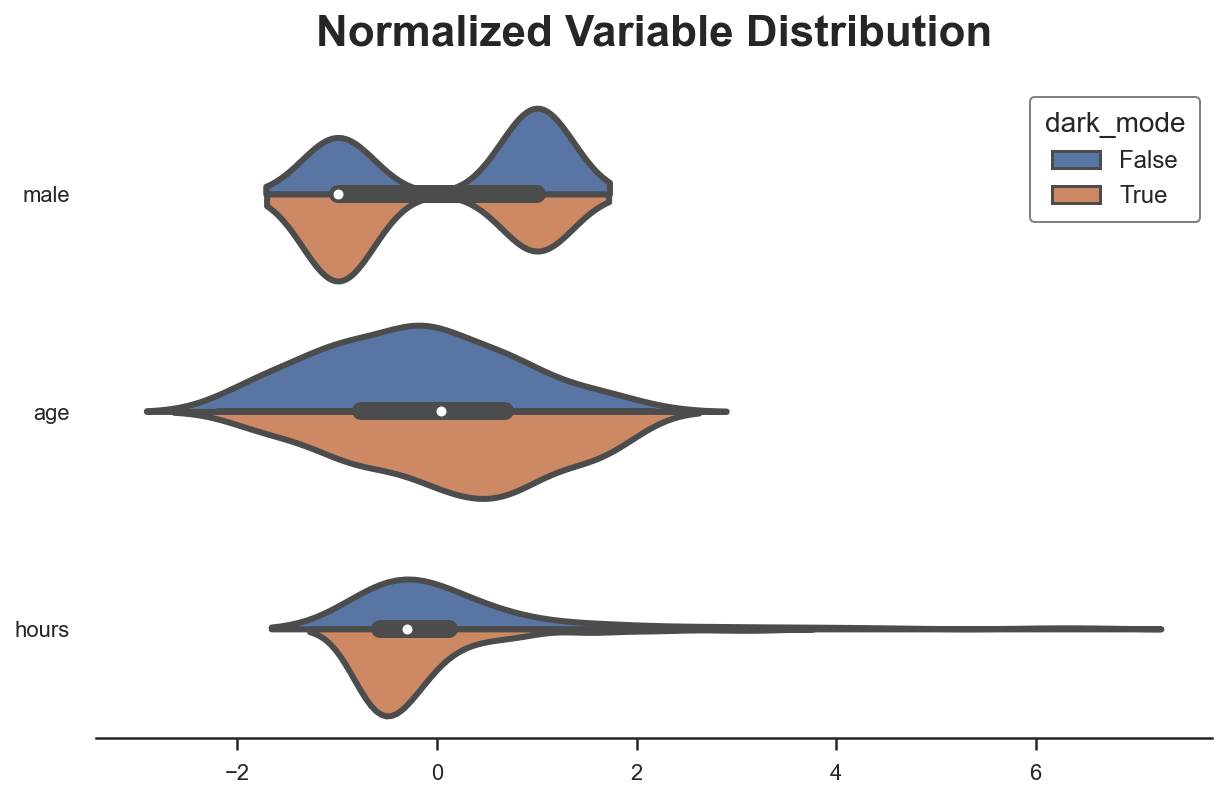

In [6]:
plot_distributions(df, X, "dark_mode")

If we do not control for the observable characteristics, we are unable to estimate the true treatment effect.

```mermaid
flowchart TB
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

X1((gender))
X2((age))
X3((hours))
D((dark mode))
Y((read time))

D --> Y
X1 --> Y
X1 --> D
X2 --> D
X2 --> Y
X3 --> D
X3 --> Y

linkStyle 0 stroke:#00ff00,stroke-width:4px;
linkStyle 1,2,3,4,5,6 stroke:#ff0000,stroke-width:4px;
class D,Y included;
class X1,X2,X3 excluded;
```

By controlling for observable characteristics, we "block" the backdoor paths and we are able to recover the causal effect of $D$ on $Y$.

```mermaid
flowchart TB
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

X1((gender))
X2((age))
X3((hours))
D((dark mode))
Y((read time))

D --> Y
X1 -.-> Y
X1 -.-> D
X2 -.-> D
X2 -.-> Y
X3 -.-> D
X3 -.-> Y

linkStyle 0 stroke:#00ff00,stroke-width:4px;
class D,Y,X1,X2,X3 included;
```

How do we do it? We have some options:

- Matching
- Propensity score weighting
- Regression with control variables

How do the methods work and what are the differences?

## Methods

We assume that for a set of i.i.d. subjects $i = 1, ..., n$ we observed a tuple $(X_i, T_i, Y_i)$ comprised of 

- a feature vector $X_i \in \mathbb R^n$
- a treatment assignment $T_i \in \lbrace 0, 1 \rbrace$
- a response $Y_i \in \mathbb R$

**Assumption 1 : unconfoundedness** (or ignorability, or selection on observables)

$$
\big \lbrace Y_i^{(1)} , Y_i^{(0)} \big \rbrace \ \perp \ T_i \ | \ X_i
$$

i.e. conditional on observable characteristics $X$, the treatment assignment $T$ is as good as random.

**Assumption 2: overlap** (or bounded support)

$$
\exists \eta > 0 \ : \ \eta \leq \mathbb E \left[ T_i = 1 \ \big | \ X_i = x \right] \leq 1-\eta
$$

i.e. no observation is deterministically assigned to the treatment or control group. 

### Matching

In [7]:
from causalml.match import NearestNeighborMatch, create_table_one

psm = NearestNeighborMatch(replace=True, ratio=1, random_state=42)
df_matched = psm.match(data=df, treatment_col="dark_mode", score_cols=X)
df_matched.head()

,read_time,dark_mode,male,age,hours
0,9.25,True,0,43.0,79.17
3,15.70,True,0,41.0,133.30
4,15.80,True,0,29.0,179.65
5,13.11,True,0,64.0,176.05
7,10.83,True,0,53.0,241.40


In [8]:
table1_matched = create_table_one(df_matched, "dark_mode", X)
table1_matched

,Control,Treatment,SMD
Variable,,,
n,134,134,
age,44.54 (10.98),44.57 (11.06),0.0034
hours,147.78 (111.68),147.94 (120.86),0.0014
male,0.43 (0.50),0.43 (0.50),0.0


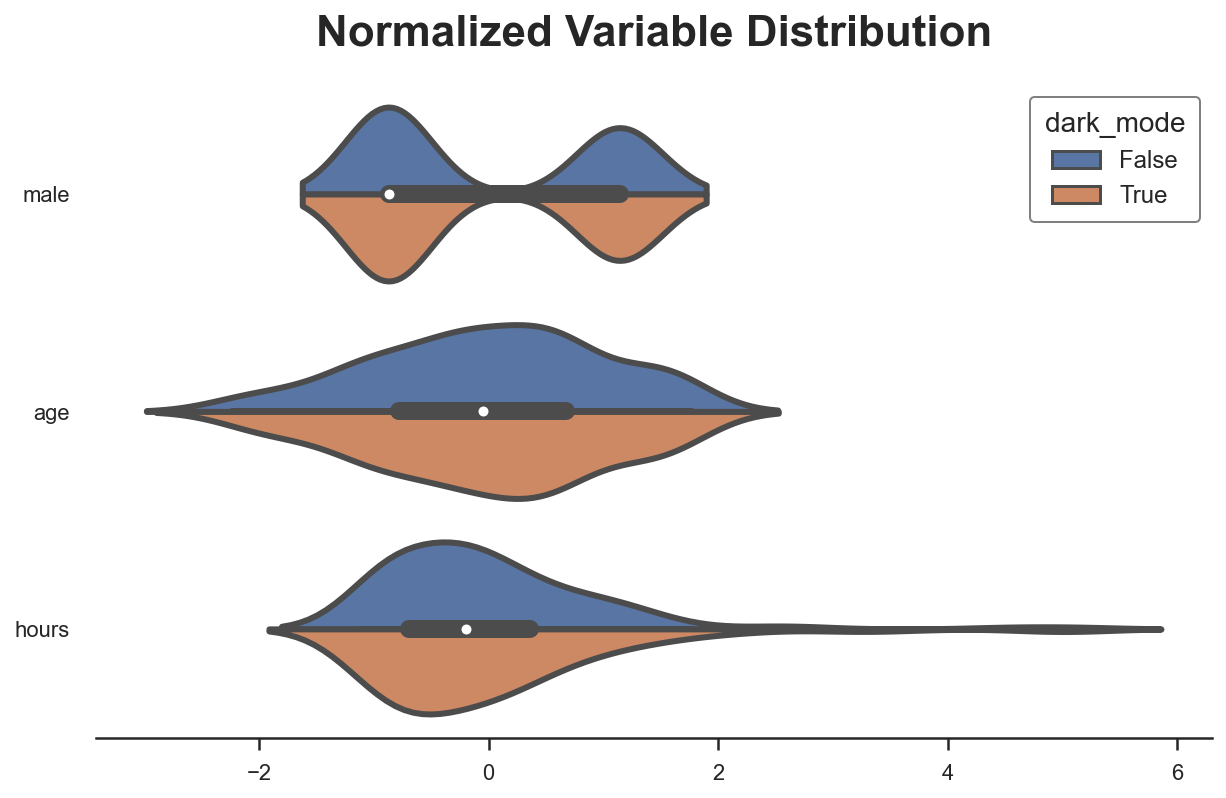

In [9]:
plot_distributions(df_matched, X, "dark_mode")

We can also compare the balancedness before and after matching by plotting the standardized mean differences.

In [10]:
def plot_balance(t1, t2, X):
    df_smd = pd.DataFrame({"Variable": X + X,
                           "Data": ["Original" for _ in range(len(X))] + ["Matched" for _ in range(len(X))],
                           "Standardized Mean Difference": t1["SMD"][1:].to_list() + 
                                                           t2["SMD"][1:].to_list()})

    sns.scatterplot(x="Standardized Mean Difference", y="Variable", hue="Data", data=df_smd).\
        set(title="Balance Plot")
    plt.axvline(x=0, color='k', ls='--', zorder=-1, alpha=0.3);

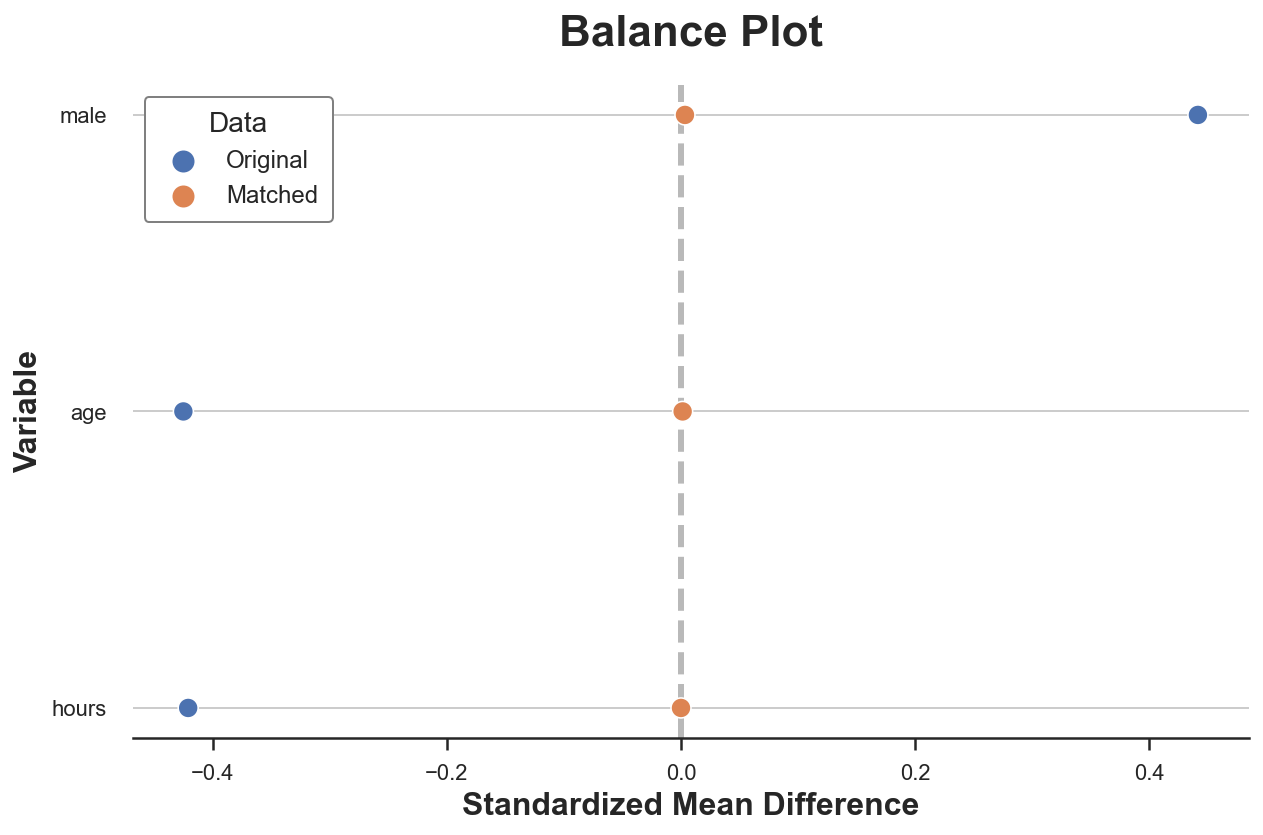

In [11]:
plot_balance(table1, table1_matched, X)

We can now estimate the treatment effect as a difference in means.

In [12]:
smf.ols("read_time ~ dark_mode", data=df_matched).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,15.1301,0.437,34.623,0.000,14.270,15.991
dark_mode[T.True],0.7602,0.618,1.230,0.220,-0.457,1.977


### Propensity Score

We want to estimate the **average treatment effect**

$$
\tau(x) = \mathbb E \left[ Y^{(1)} - Y^{(0)} \ \big| \ X = x \right]
$$

We would like to obtain an unbiased estimator that satifies a central limit theorem of the form

$$
\sqrt{n} ( \hat \tau - \tau) \ \overset{d}{\to} \ N(0, V)
$$

thus enabling us to construct **confidence intervals**.

Under **unconfoundedness**, we can rewrite the average treatment effect as

$$
\tau(x) = \mathbb E \left[ Y^{(1)} - Y^{(0)} \ \big| \ X = x \right] = \mathbb E \left[ \frac{T_i Y_i}{e(X_i)} - \frac{(1-T_i) Y_i}{1-e(X_i)} \right]
$$

where $e(X_i)$ is the **propensity score** of observation $i$, 

$$
e(x) = \mathbb P \left[ T_i = 1 \ \big | \ X_i = x \right]
$$

i.e. its probability of being treated.

Note that this formulation of the average treatment effect does not depend on the potential outcomes $Y_i^{(1)}$ and $Y_i^{(0)}$, but only on the observed outcomes $Y_i$.

This formulation of the average treatment effect implies the **Inverse Propensity Weighted** estimator which is an unbiased estimator for the average treatment effect $\tau$ 

$$
\hat \tau^{*}_{IPW} = \frac{1}{n} \sum _ {i=1}^{n} \left( \frac{T_i Y_i}{e(X_i)} - \frac{(1-T_i) Y_i}{1-e(X_i)} \right)
$$

However, this estimator is **unfeasible** since we do not observe the propensity scores $e(X_i)$.

In [13]:
df["pscore"] = smf.logit("np.rint(dark_mode) ~ male + age + hours", data=df).fit(disp=False).predict()

Is the sample balanced?

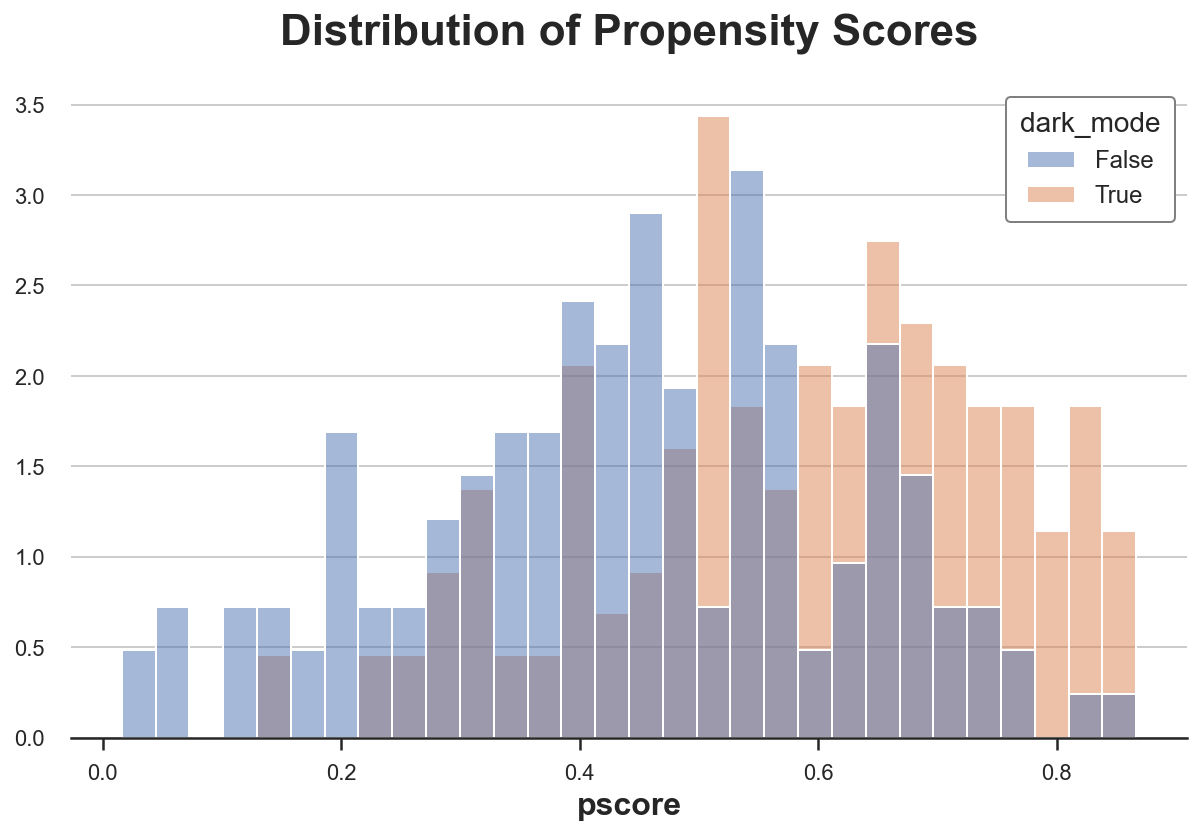

In [14]:
sns.histplot(data=df, x='pscore', hue='dark_mode', bins=30, stat='density', common_norm=False).\
    set(ylabel="", title="Distribution of Propensity Scores");

As we can see, the distribution of propensity scores between the treatment and control group is **significantly different**.

We can now estimate the treatment effect as a weighted difference in means.

In [15]:
w = 1 / (df["pscore"] * df["dark_mode"] + (1-df["pscore"]) * (1-df["dark_mode"]))
smf.wls("read_time ~ dark_mode", weights=w, data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,14.9446,0.434,34.397,0.000,14.090,15.800
dark_mode[T.True],1.9734,0.613,3.219,0.001,0.767,3.180


Lastly, an extremely interesting result from 

### Regression with Control Variables

In [16]:
smf.ols("read_time ~ dark_mode + male + age + hours", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.9298,1.183,10.931,0.000,10.602,15.258
dark_mode[T.True],1.8801,0.610,3.081,0.002,0.679,3.081
male,2.1708,0.584,3.718,0.000,1.022,3.320
age,-0.0063,0.026,-0.243,0.808,-0.058,0.045
hours,0.0047,0.001,5.009,0.000,0.003,0.007


What is the connection between regression and propensity score weighting? 



## Conclusion

TBD

### References

TBD

### Related Articles

- [Understanding The Frisch-Waugh-Lovell Theorem](https://towardsdatascience.com/59f801eb3299)
- [How to Compare Two or More Distributions](https://towardsdatascience.com/9b06ee4d30bf)
- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/ipw.ipynb